### Phase analysis - General Approach

Example for pairs composed of F1 (83) channel

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircstat
import pycircular
import scipy
import seaborn as sns
import xarray as xr
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd, circvar
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from xarray_einstats.stats import circmean, circstd

from frites.conn import conn_reshape_undirected
from frites.plot import plot_conn_heatmap
from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [4]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

In [5]:
def find_start_end(array, find_zeros=False):
    """
    Given a binary array find the indexes where the sequences of ones start
    and begin if find_zeros is False. Otherwise it will find the indexes where
    the sequences of zeros start and begin. For instance, for the array
    [0,1,1,1,0,0], would return 1 and 3 respectively for find_zeros=False,
    and 1 and 2 for find_zeros=True.

    Parameters
    ----------
    array: array_like
        Binary array.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones

    Returns
    -------
    The matrix containing the start anb ending index
    for each sequence of consecutive ones or zeros with shapes [n_seqs,2]
    where n_seqs is the number of sequences found.
    """
    if find_zeros:
        _bounds = np.array([1])
    else:
        _bounds = np.array([0])

    bounded = np.hstack((_bounds, array, _bounds))
    difs = np.diff(bounded)
    # get 1 at run starts and -1 at run ends if find_zeros is False
    if not find_zeros:
        (run_starts,) = np.where(difs > 0)
        (run_ends,) = np.where(difs < 0)
    # get -1 at run starts and 1 at run ends if find_zeros is True
    else:
        (run_starts,) = np.where(difs < 0)
        (run_ends,) = np.where(difs > 0)
    return np.vstack((run_starts, run_ends)).T


def find_activation_sequences(spike_train, find_zeros=False, dt=None, pad=False):
    """
    Given a spike-train, it finds the length of all activations in it.
    For example, for the following spike-train: x = {0111000011000011111},
    the array with the corresponding sequences of activations (ones) will be
    returned: [3, 2, 5] (times dt if this parameter is provided).

    Parameters
    ----------
    spike_train: array_like
        The binary spike train.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones
    dt: int | None
        If provided the returned array with the length of activations
        will be given in seconds.

    Returns
    -------
    act_lengths: array_like
        Array containing the length of activations with shape [n_seqs]
        where n_seqs is the number of sequences found.
    """

    # If no dt is specified it is set to 1
    if dt is None:
        dt = 1
    out = find_start_end(spike_train, find_zeros=find_zeros)
    act_lengths = (out[:, 1] - out[:, 0]) * dt

    if pad:
        _new_size = len(spike_train) // 2 + 1
        act_lengths = _nan_pad(act_lengths, _new_size, 0)

    return act_lengths

In [6]:
from functools import partial

import jax
import jax.numpy as jnp

_pi = jnp.pi


@jax.jit
def Gvalue(x: jnp.ndarray, y: jnp.ndarray) -> float:
    return np.sum(_pi - jnp.abs(_pi - jnp.abs(x[:, None] - y)))


def Gtest(
    x: jnp.ndarray, y: jnp.ndarray, n_perm: int = 100, seed_key: int = 0
) -> float:

    # Number of samples in each array
    n1, n2 = x.shape[0], y.shape[0]
    # Total number of samples
    n = n1 + n2

    factor = jnp.sqrt(n / (n1 * n2))

    # Combined samples
    combsample = jnp.hstack((x, y))

    # Compute G statistic for the data
    Gstat = factor * Gvalue(x, y)

    # Initial pvalue
    pvalue = 1

    # Sample indexes
    indexes = jnp.arange(0, n)

    seeds = jax.random.randint(jax.random.key(seed_key), (n_perm,), 0, 20000)

    @partial(jax.vmap, in_axes=(None, 0))
    def _loop(indexes, seed):

        indexes = jax.random.permutation(jax.random.key(seed), indexes)
        randsamp1 = combsample[indexes[: n1 + 1]]
        randsamp2 = combsample[indexes[n1:n]]
        Grand = factor * Gvalue(randsamp1, randsamp2)

        return Grand >= Gstat

    return _loop(indexes, seeds).sum() / (n_perm + 1)

In [7]:
_pi = np.pi
_2pi = 2 * _pi


def WatsonTwoTestRad(x: np.ndarray, y: np.ndarray):
    n1 = len(x)
    n2 = len(y)
    n = n1 + n2

    x = np.stack((np.sort(x % _2pi), [1] * n1), axis=1)
    y = np.stack((np.sort(y % _2pi), [2] * n2), axis=1)

    xx = np.concatenate((x, y), axis=0)

    rank = np.argsort(xx[:, 0])

    xx = np.concatenate((xx[rank], np.arange(1, n + 1)[:, None]), axis=1)

    a = np.cumsum(xx[:, 1] == 1)
    b = np.cumsum(xx[:, 1] == 2)

    d = b / n2 - a / n1
    dbar = np.mean(d)
    return (n1 * n2) / (n * n) * np.sum((d - dbar) ** 2)

#### Load data

In [8]:
DATA_PATH = os.path.expanduser(
    "/home/vinicius/funcog/phaseanalysis/Results/lucy/141017"
)


def load_channel_pair(path2data: str, roi_a: str, roi_b: str, band: int):

    average_power_epochs = xr.load_dataarray(
        os.path.join(DATA_PATH, "average_power.nc")
    )

    power_time_series = xr.open_dataarray(
        os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
    )

    phase_time_series = xr.open_dataarray(
        os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
    )

    phi_series = xr.open_dataarray(
        os.path.join(
            DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc"
        )
    )

    phi_series_surr = xr.open_dataarray(
        os.path.join(
            DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc"
        )
    )

    power_time_series = power_time_series.sel(roi=[roi_a, roi_b]).load()
    phase_time_series = phase_time_series.sel(roi=[roi_a, roi_b]).load()
    phi_series = phi_series.sel(roi=[f"{roi_a}-{roi_b}"]).load()
    phi_series_surr = phi_series_surr.sel(roi=[f"{roi_a}-{roi_b}"]).load()
    # phi_series_surr = phi_series_surr.load()

    return power_time_series, phase_time_series, phi_series, phi_series_surr

In [9]:
average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))

power_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"power_time_series_band_1_surr_False.nc")
)

power_time_series.roi.values

array(['a46D_1', 'a8B_4', 'F6_8', 'a9/46D_9', 'a8M_10', 'a8B_11',
       'a8B_12', 'F7_13', 'F7_14', 'a8r_15', 'a8M_16', 'a8M_17', 'a8B_18',
       'F7_19', 'F7_20', 'a8L_21', 'a8r_22', 'a8M_23', 'F2_28', 'a44_29',
       'F2_36', 'a8L_39', 'a8L_40', 'F2_43', 'F2_44', 'F2_45', 'F2_54',
       'F1_63', 'a3_64', 'a3_65', 'F1_69', 'F1_73', 'F1_83', 'F1_84',
       'a2_86', 'F1_92', 'F1_95', 'a1_101', 'a1_103', 'F1_104', 'F1_105',
       'a3_106', 'a7B_110', 'a2_112', 'a1_114', 'a1_115', 'a1_116',
       'a3_117', 'a7B_121', 'a7B_122', 'a5_124', 'a2_125', 'a2_126',
       'a1_127', 'a5_136', 'a2_138', 'TPt_141', 'a5_149', 'a7A_156',
       'a5_161', 'V4t_163', 'DP_168', 'a5_172', 'MT_175', 'DP_177',
       'a7A_181', 'V6A_183', 'DP_191', 'PIP_193', 'V2_203', 'V6A_205',
       'V1_212', 'V2_214', 'V2_215', 'V2_222', 'V1_232', 'V1_241',
       'V1_242', 'V1_245', 'V1_248', 'V1_250', 'V1_251'], dtype='<U8')

In [27]:
roi_a, roi_b = (
    "F1_83",
    "F1_84",
)

power_time_series, phi_series, phi_series_surr = [], [], []

for band in tqdm(range(16)):
    out = load_channel_pair(DATA_PATH, roi_a, roi_b, band)
    power_time_series += [out[0]]
    phi_series += [out[2]]
    phi_series_surr += [out[3]]

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [02:31<00:00,  9.47s/it]


In [28]:
power_time_series = xr.concat(power_time_series, "freqs")
phi_series = xr.concat(phi_series, "freqs")
phi_series_surr = xr.concat(phi_series_surr, "freqs")

In [29]:
freqs = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

#### Compute power envelope correlations

In [30]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def _int(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_int(w_x, w_y):
        # computes fraciton of events above threshold that intersect
        x = w[:, w_x, :, :]
        y = w[:, w_y, :, :]
        prod = x * y
        #norm = np.max([x.sum(-1), y.sum(-1)], axis=0)
        #norm = np.where(norm == 0, 1, norm)
        return prod

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_int, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_events_coincidence(
    power, q_l, q_u=None, n_jobs=1, verbose=False, shuffle=False
):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    quantiles = power.quantile(q_l, "times")

    z_power = (power >= quantiles).values

    if isinstance(q_u, float):
        quantiles = power.quantile(q_u, "times")
        z_power = np.logical_and(z_power, power < quantiles).values

    if shuffle:
        z_power = shuffle_along_axis(z_power, 0)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _int(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )

    return pec

In [49]:
pec = power_events_coincidence(power_time_series, 0.6)

Defining links (n_roi=2; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [50]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True)

Defining links (n_roi=2; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/1 [00:00<?,       ?it/s]

#### Compute phase relations

In [51]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [52]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(~pec_shuffle, np.nan, phi_series_surr),
    dims=phi_series_surr.dims,
    coords=phi_series_surr.coords,
)

In [53]:
edges = phi_series.roi.data

In [54]:
roi_s, roi_t = _extract_roi(edges, "-")

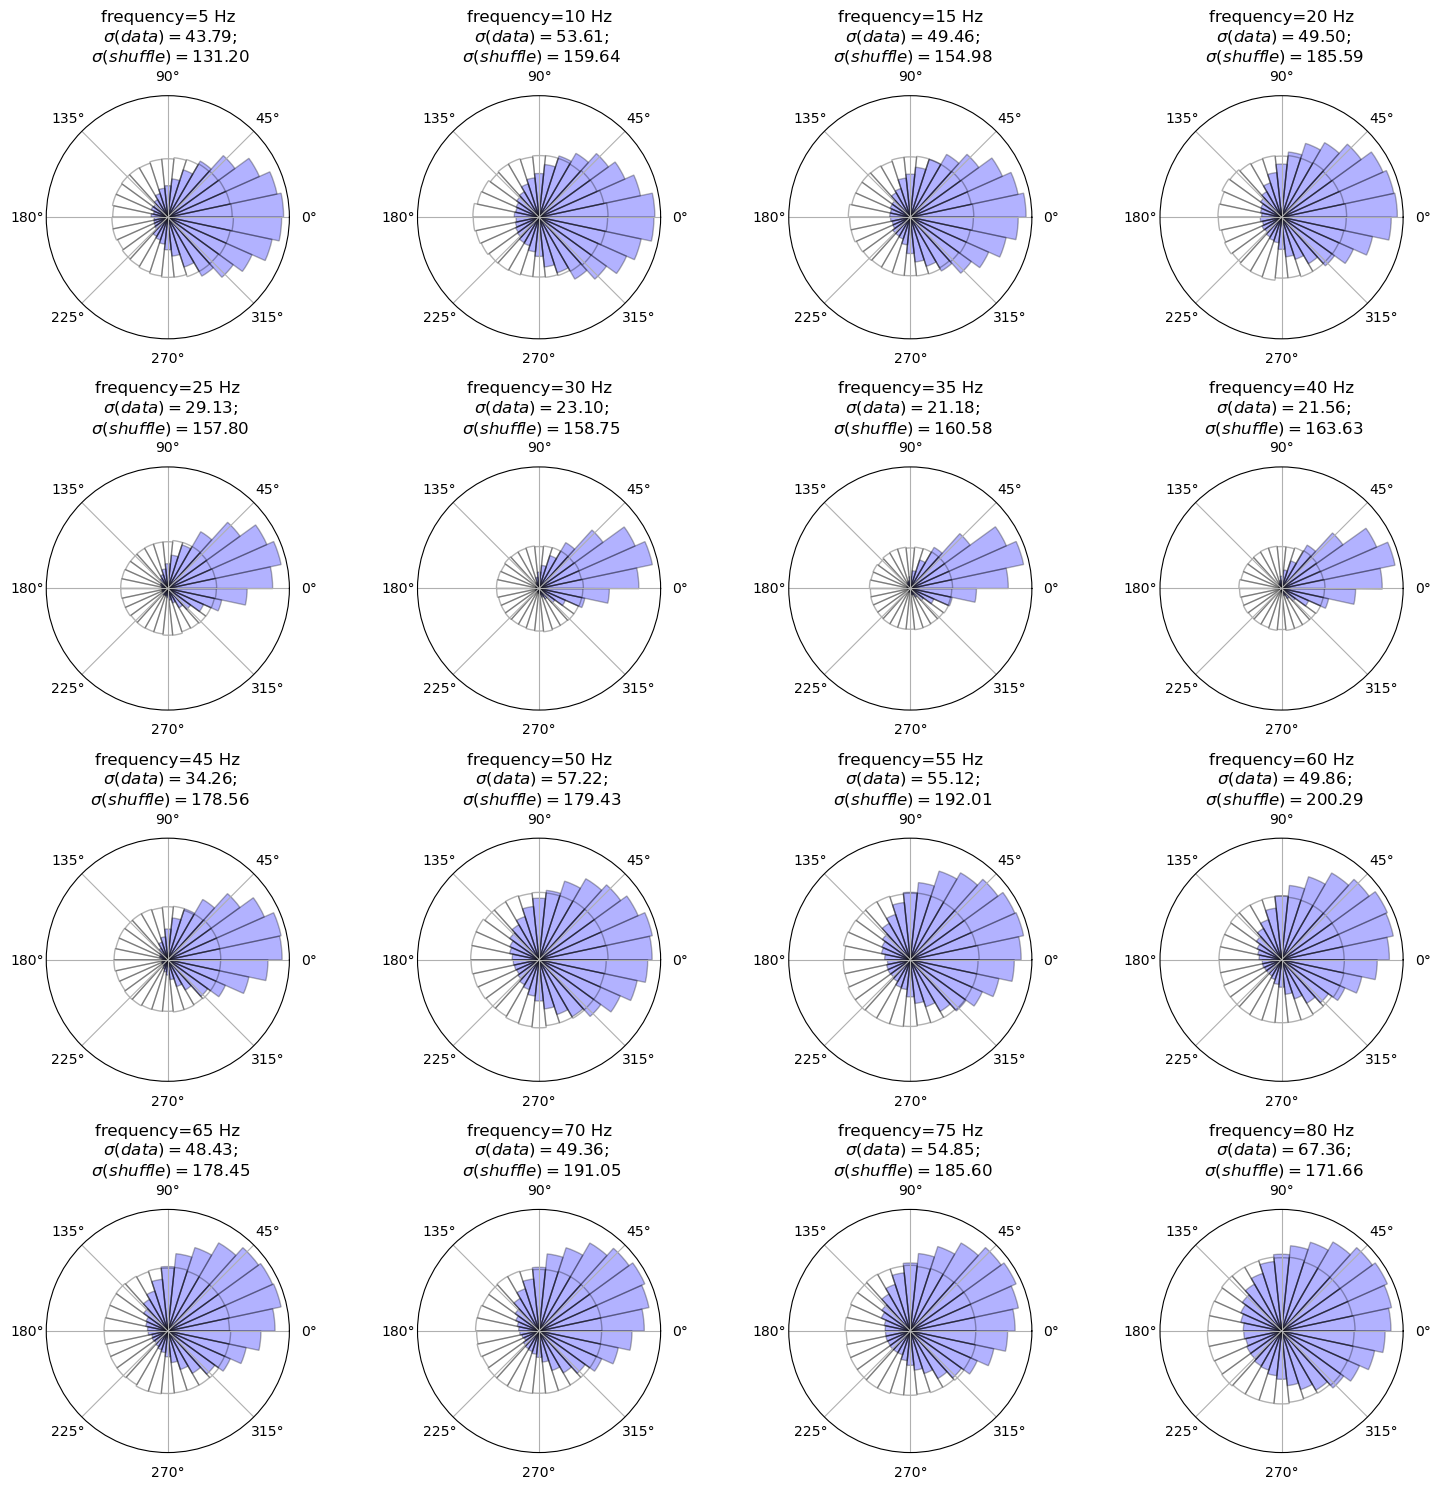

In [55]:
plt.figure(figsize=(15, 15))

for pp, freq in enumerate(pec.freqs.values):

    ax = plt.subplot(4, 4, pp + 1, projection="polar")

    out = filtered_phi_series.sel(freqs=freq).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )

    out_shuffle = filtered_phi_series_shuffle.sel(freqs=freq).data.flatten()
    out_shuffle = out_shuffle[~np.isnan(out_shuffle)]

    circular_hist(
        ax,
        out_shuffle,
        bins=30,
        fill=False,
    )
    sig = scipy.stats.circstd(out) * 180 / np.pi
    sig_shuffle = scipy.stats.circstd(out_shuffle) * 180 / np.pi
    # pval = pycircstat.tests.watson_williams(out, out_shuffle)#WatsonTwoTestRad(out, out_shuffle)
    nl = "\n"
    plt.title(
        rf"frequency={freqs[pp]} Hz{nl} $\sigma(data) = {sig:.2f}$;{nl} $\sigma(shuffle) = {sig_shuffle:.2f}$"
    )
plt.tight_layout()
plt.savefig(
    f"figures/example_channel_pairs/phase_distributions_all_freqs_{roi_a}_{roi_b}.png"
)

In [56]:
size = (~(filtered_phi_series.squeeze().isnull())).sum(("times", "trials"))
size_shuffle = (~(filtered_phi_series_shuffle.squeeze().isnull())).sum(
    ("times", "trials")
)

In [57]:
phi_max = np.sqrt(np.log(size))
phi_max_shuffle = np.sqrt(np.log(size_shuffle))

In [58]:
std = [
    scipy.stats.circstd(filtered_phi_series.isel(freqs=i), nan_policy="omit")
    for i in tqdm(range(len(freqs)))
]

std = xr.DataArray(std, dims="freqs", coords=(freqs,))

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.82it/s]


In [59]:
std_shuffle = [
    scipy.stats.circstd(filtered_phi_series_shuffle.isel(freqs=i), nan_policy="omit")
    for i in tqdm(range(len(freqs)))
]

std_shuffle = xr.DataArray(std_shuffle, dims="freqs", coords=(freqs,))

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.03it/s]


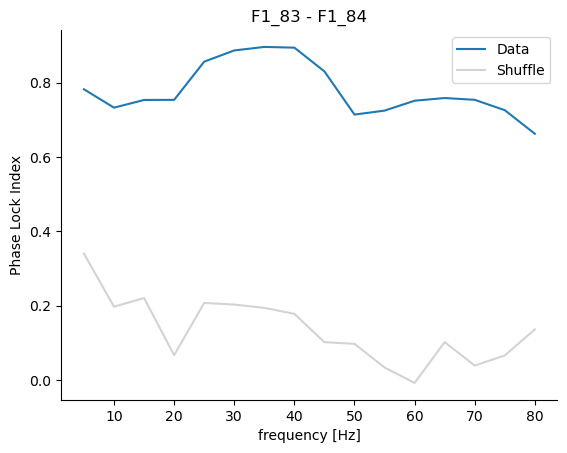

In [60]:
ax = plt.subplot(111)
(1 - std / phi_max).plot(x="freqs")
(1 - std_shuffle / phi_max_shuffle).plot(x="freqs", c="lightgray")
plt.legend(["Data", "Shuffle"])
plt.ylabel("Phase Lock Index")
plt.xlabel("frequency [Hz]")
plt.title(f"{roi_a} - {roi_b}")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig(
    f"figures/example_channel_pairs/phase_lock_index_all_freqs_{roi_a}_{roi_b}.png"
)

#### Duration distributions

In [83]:
x = pec.squeeze()
d = np.zeros((398, 16))
for i in tqdm(range(398)):
    for k in range(16):
        d[i, k] = find_activation_sequences(x[i, k], dt=1).mean()

d = xr.DataArray(
    d,
    dims=("trials", "freqs"),
    coords=(pec.trials.values, freqs),
)

100%|█████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 270.73it/s]


In [84]:
x = pec_shuffle.squeeze()
d_shuffle = np.zeros((398, 16))
for i in tqdm(range(398)):
    for k in range(16):
        d_shuffle[i, k] = find_activation_sequences(x[i, k], dt=1).mean()

d_shuffle = xr.DataArray(
    d_shuffle,
    dims=("trials", "freqs"),
    coords=(pec.trials.values, freqs),
)

100%|█████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 273.55it/s]


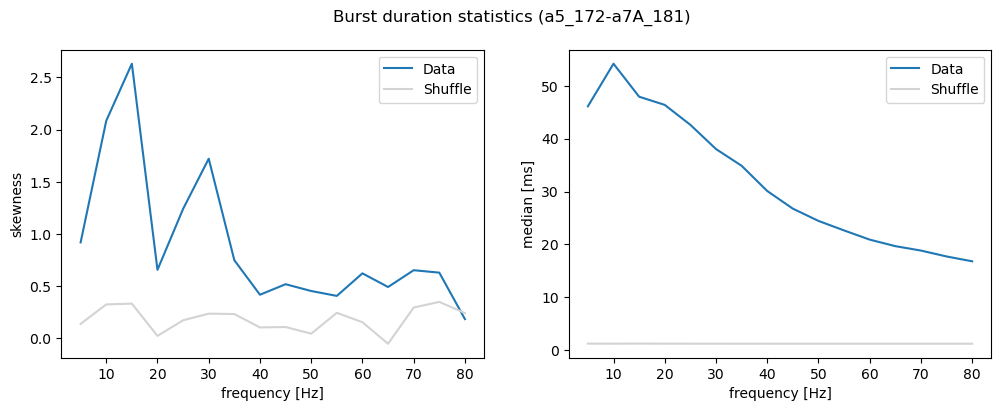

In [85]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(freqs, scipy.stats.skew(d, axis=0))
plt.plot(freqs, scipy.stats.skew(d_shuffle, axis=0), c="lightgray")
plt.legend(["Data", "Shuffle"])
plt.ylabel("skewness")
plt.xlabel("frequency [Hz]")
plt.subplot(122)
plt.plot(freqs, np.median(d, axis=0))
plt.plot(freqs, np.median(d_shuffle, axis=0), c="lightgray")
plt.legend(["Data", "Shuffle"])
plt.ylabel("median [ms]")
plt.xlabel("frequency [Hz]")
plt.suptitle(f"Burst duration statistics ({roi_a}-{roi_b})")
plt.savefig(
    f"figures/example_channel_pairs/duration_skewness_all_freqs_{roi_a}_{roi_b}.png"
)

### Sub-network

In [86]:
rois = ["a8M_17", "a1_103", "a7B_121", "a2_125", "a5_172", "a7A_181"]

In [252]:
band = 6

average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))

power_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
)

phase_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
)

phi_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc")
)

phi_series_surr = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc")
)

In [253]:
roi_s, roi_t = _extract_roi(phi_series.roi.data, "-")

In [254]:
indexes = []


for s in rois:
    for t in rois:
        if s != t:
            indexes += [
                np.logical_or(
                    np.logical_and(s == roi_s, t == roi_t),
                    np.logical_and(t == roi_t, s == roi_s),
                )
            ]
indexes = np.stack(indexes).sum(0).astype(bool)

In [255]:
power_time_series = power_time_series.sel(roi=rois).load()
phase_time_series = phase_time_series.sel(roi=rois).load()
phi_series = phi_series.isel(roi=indexes).load()
phi_series_surr = phi_series_surr.isel(roi=indexes).load()

In [256]:
pec = power_events_coincidence(power_time_series, 0.6).sel(roi=phi_series.roi.values)

Defining links (n_roi=6; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/15 [00:00<?,       ?it/s]

In [257]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True).sel(
    roi=phi_series.roi.values
)

Defining links (n_roi=6; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/15 [00:00<?,       ?it/s]

In [258]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [285]:
filtered_phi_series.dims

('trials', 'roi', 'freqs', 'times')

In [286]:
scipy.stats.circstd(filtered_phi_series, axis=(0, 3), nan_policy="omit").shape

(15, 1)

In [259]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(~pec_shuffle, np.nan, phi_series_surr),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [260]:
edges = phi_series.roi.data

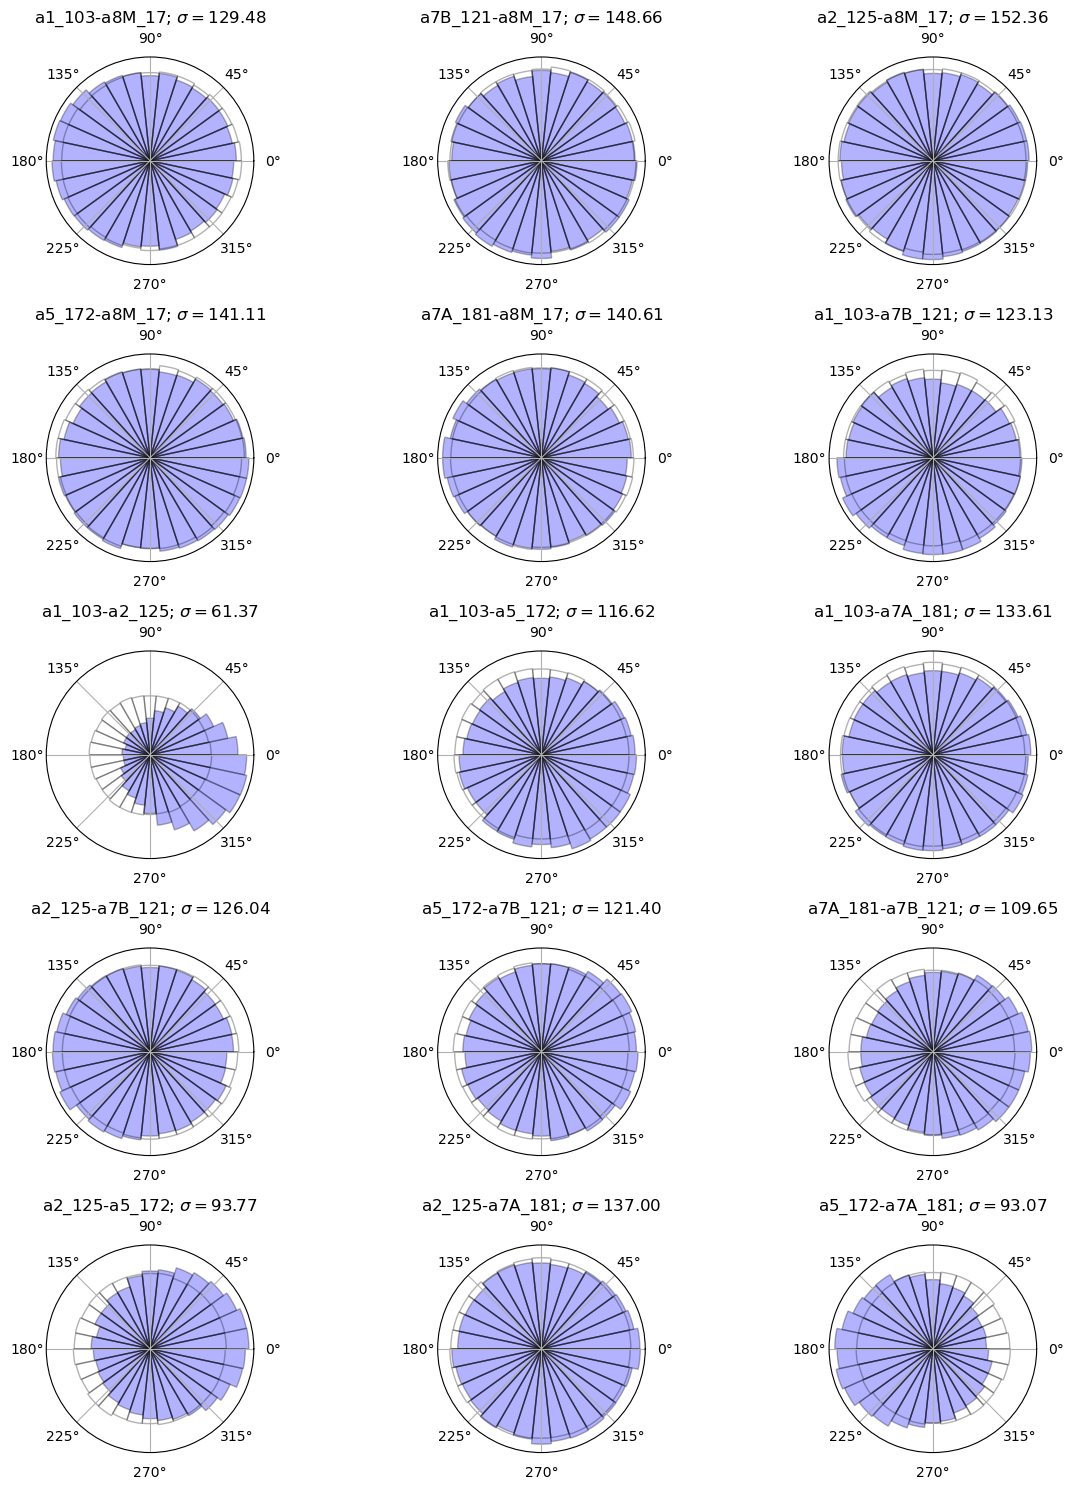

In [261]:
plt.figure(figsize=(12, 15))

mu, sig = [], []

for pp, roi in enumerate(pec.roi.values):

    ax = plt.subplot(5, 3, pp + 1, projection="polar")

    out = filtered_phi_series.sel(roi=roi).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )

    out_shuffle = filtered_phi_series_shuffle.sel(roi=roi).data.flatten()
    out_shuffle = out_shuffle[~np.isnan(out_shuffle)]

    circular_hist(
        ax,
        out_shuffle,
        bins=30,
        fill=False,
    )

    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)

    mu += [m_1]
    sig += [m_2]
    plt.title(rf"{roi}; $\sigma = {(m_2 * 180 / np.pi):.2f}$")

plt.tight_layout()

In [262]:
sig = xr.DataArray(sig, dims=("roi"), coords=(edges,))

In [271]:
phi_max = np.sqrt(
    np.log(1e6)
)

In [272]:
pli = 1 - sig / phi_max

In [273]:
xy = scipy.io.loadmat("../Brain Areas/lucy_brainsketch_xy.mat")["xy"]

In [274]:
def plot_brain_sketch(ax):
    png = plt.imread("../Brain Areas/ethyl_brainsketch.jpg")
    plt.sca(ax)
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")
    pad = 10
    plt.xlim(-pad, png.shape[1] + pad)
    plt.ylim(png.shape[0] + pad, -pad)

In [275]:
roi_s, roi_t = _extract_roi(edges, "-")
ch_s, _ = _extract_roi(roi_s, "_")
ch_t, _ = _extract_roi(roi_t, "_")
ch_s = ch_s.astype(int) - 1
ch_t = ch_t.astype(int) - 1

In [276]:
import matplotlib

In [277]:
vmin = np.min(pli.values)
vmax = np.max(pli.values)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = matplotlib.colormaps["viridis_r"]
colors = [cmap(norm(val)) for val in pli.values]

Text(0.5, 0.98, 'frequency = 10 Hz')

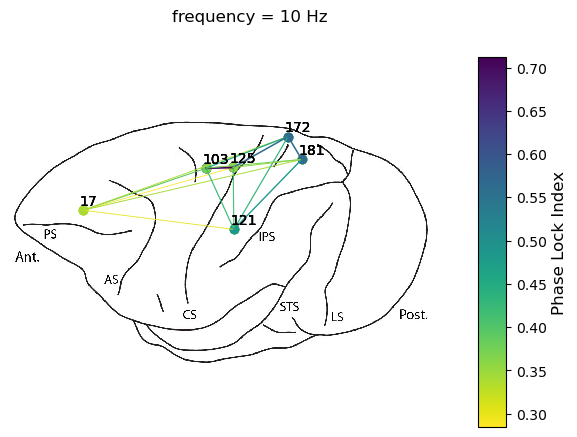

In [278]:
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[15, 1])
ax1 = plt.subplot(gs[0])
plot_brain_sketch(ax1)
pos = 0
for (
    s,
    t,
) in zip(ch_s, ch_t):
    x = [xy[s, 0], xy[t, 0]]
    y = [xy[s, 1], xy[t, 1]]
    plt.plot(x, y, color=colors[pos], lw=pli[pos].values * 2)
    plt.scatter(x, y, color=colors[pos])
    plt.text(x[0] - 10, y[0] - 15, s + 1)
    plt.text(x[1] - 10, y[1] - 15, t + 1)
    pos = pos + 1

ax2 = plt.subplot(gs[1])
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap="viridis_r", norm=norm), cax=ax2)

cbar.ax.set_ylabel("Phase Lock Index", rotation="vertical", fontsize=12)

plt.suptitle("frequency = 10 Hz")

#### F1 (83) Network

In [26]:
band = 1

average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))

power_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
)

phase_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
)

phi_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc")
)

phi_series_surr = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc")
)

In [27]:
roi_s, roi_t = _extract_roi(phi_series.roi.data, "-")

In [28]:
indexes = np.logical_or(roi_s == "F1_83", roi_t == "F1_83")

In [29]:
roi = np.unique((roi_s[indexes], roi_t[indexes]))

In [30]:
power_time_series = power_time_series.sel(roi=roi).load()
phase_time_series = phase_time_series.sel(roi=roi).load()
phi_series = phi_series.isel(roi=indexes).load()
phi_series_surr = phi_series_surr.isel(roi=indexes).load()

In [31]:
pec = power_events_coincidence(power_time_series, 0.6).sel(roi=phi_series.roi.values)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [ ]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True).sel(
    roi=phi_series.roi.values
)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [ ]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [ ]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(~pec_shuffle, np.nan, phi_series_surr),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [ ]:
edges = phi_series.roi.data

In [ ]:
plt.figure(figsize=(15, 15))

mu, sig = [], []

for pp, roi in enumerate(pec.roi.values):

    ax = plt.subplot(9, 9, pp + 1, projection="polar")

    out = filtered_phi_series.sel(roi=roi).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )

    out_shuffle = filtered_phi_series_shuffle.sel(roi=roi).data.flatten()
    out_shuffle = out_shuffle[~np.isnan(out_shuffle)]

    circular_hist(
        ax,
        out_shuffle,
        bins=30,
        fill=False,
    )

    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)

    mu += [m_1]
    sig += [m_2]
    plt.title(roi)

plt.tight_layout()

plt.savefig(f"figures/band{band}/phase_distributions_F1_83_pairs.pdf")

In [ ]:
mu = xr.DataArray(mu, dims=("roi"), coords=(edges,))
sig = xr.DataArray(sig, dims=("roi"), coords=(edges,))

In [ ]:
x = pec.squeeze()
d = np.zeros((pec.sizes["trials"], pec.sizes["roi"]))
for i in tqdm(range(pec.sizes["trials"])):
    for k in range(pec.sizes["roi"]):
        d[i, k] = find_activation_sequences(x[i, k], dt=1).mean()

d = xr.DataArray(
    d,
    dims=("trials", "roi"),
    coords=(pec.trials.values, edges),
)

In [ ]:
plt.figure(figsize=(15, 15))


bins = np.linspace(d.min(), d.max(), 50)

for pp, roi in enumerate(pec.roi.values):

    ax = plt.subplot(9, 9, pp + 1)

    plt.hist(d[:, pp], bins)
    plt.xlabel("duration [ms]")
    plt.ylabel("#")
    plt.title(roi)

plt.tight_layout()

plt.savefig(f"figures/band{band}/duration_distributions_F1_83_pairs.pdf")

In [ ]:
plt.scatter(d.median("trials"), sig)

In [ ]:
_2pi = 2 * np.pi


def WatsonTwoTestRad(x: np.ndarray, y: np.ndarray):
    n1 = len(x)
    n2 = len(y)
    n = n1 + n2

    x = np.stack((np.sort(x % _2pi), [1] * n1), axis=1)
    y = np.stack((np.sort(y % _2pi), [2] * n2), axis=1)

    xx = np.concatenate((x, y), axis=0)

    rank = np.argsort(xx[:, 0])

    xx = np.concatenate((xx[rank], np.arange(1, n + 1)[:, None]), axis=1)

    a = np.arange(1, n + 1, dtype=int)
    b = np.arange(1, n + 1, dtype=int)

    for i in range(n):
        a[i] = np.sum(xx[0 : i + 1, 1] == 1)
        b[i] = np.sum(xx[0 : i + 1, 1] == 2)

    d = b / n2 - a / n1
    dbar = np.mean(d)
    return (n1 * n2) / (n * n) * np.sum((d - dbar) ** 2)

In [ ]:
WatsonTwoTestRad(out, out_shuffle)

In [ ]:
out_shuffle

In [ ]:
Gtest(out, out_shuffle, 100)